## Wstęp, opis podejścia do zadania

Witam, poniższy notebook zawiera predykcje cen mieszkań (problem regresyjny) oraz predykcje czy cena mieszkania jest powyżej miliona (problem klasyfikacji binarnej). Notebook można podzielić na 4 główne części: 
-	ogólne zapoznanie się z danymi
-	badania eksploracyjne (Exploratory Data Analysis)
-	Obróbka danych (Data Preprocessing)
-	Modelowanie

Podczas realizacji zadania kierowałem się zasadą Pareto (80/20) i skupiałem się na najważniejszych aspektach z punktu widzenia Data Science. Cała praca zajęła około 5/6 godzin i miała na celu <b>zbudowanie prototypu </b>, przedstawienie podejścia do problemu oraz zaprezentowanie znajomości zaawansowanych narzędzi tj. Eli5, hyperopt oraz zaproponowane we wnioskach H2O. Oczywiście, można uzyskać jeszcze lepsze wyniki, jednak koreluje to z poświęconym czasem 😊 We wnioskach zaproponowałem możliwe udoskonalenia oraz eksperymenty, które mogą wpłynąć na końcowy rezultat.

In [1]:
### Cel

# Zbudowanie dwóch niezależnych od siebie modeli do predykcji ciągłej oraz binarnej.

### Agenda:
#### Ładowanie danych i importy
#### Ogólne zapoznanie się z danymi

# - describe
# - head
# - info

#### Badania Eksploracyjne (EDA)

# - countplot 
# - histograms
# - heatmap of correlation
# - pairplot(sometimes time-consuming)
# - scatterplots
# - boxplots

#### Obróbka danych (Data PreProcessing)
# - remove or fill any missing data
# - remove unnecessary or repetitive features
# - convert categorical string features to dummy variables

#### Modelowanie (Modeling)
# - train test split
# - normalizing Data MinMaxScaler
# - creating Model
# - evaluating model 

In [2]:
!pip install eli5

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance # sprawdzanie waznosci cech
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix, classification_report
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15713027520665796579
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14269251496938906973
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/house.csv')

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.401822e+05,3.673622e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
price_bin,21613.0,6.778328e-02,2.513795e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.114757e+00,7.701632e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00


In [8]:
df.head()

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   price_bin      21613 non-null  int64  
 4   bedrooms       21613 non-null  int64  
 5   bathrooms      21613 non-null  float64
 6   sqft_living    21613 non-null  int64  
 7   sqft_lot       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  view           21613 non-null  int64  
 11  condition      21613 non-null  int64  
 12  grade          21613 non-null  int64  
 13  sqft_above     21613 non-null  int64  
 14  sqft_basement  21613 non-null  int64  
 15  yr_built       21613 non-null  int64  
 16  yr_renovated   21613 non-null  int64  
 17  zipcode        21613 non-null  int64  
 18  lat   

In [10]:
#df.isnull().sum()

Wnioski po pierwszej czesci: kompletne dane,dane numeryczne poza datą

# EDA

In [ ]:
plt.figure(figsize = (20,12))
plt.title("Price over the years")
sns.lineplot(x=pd.to_datetime(df['date'],yearfirst= True), y=df['price'])

In [13]:
# Sprawdzmy czy jest sytuacja ze mieszkanie jest warte wiecej niz milion a w kolumnie price_bin znajduje sie niepoprawna liczba
df[(df['price'] > 1000000) & (df['price_bin'] != 1)].id.count()

0

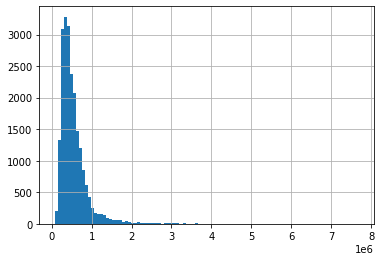

In [14]:
df['price'].hist(bins = 100)
# Mamy ogon, trzeba zlogarytmizowac
# mamy outlierow, trzeba zdropowac wiersze, gdzie cena jest wieksza niz 4mln

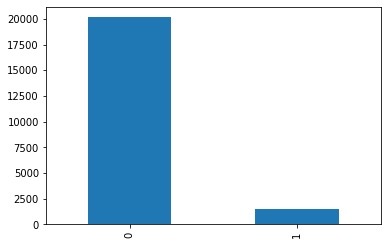

In [15]:
# Dane sa niezbalansowane
df['price_bin'].value_counts().plot(kind ='bar')

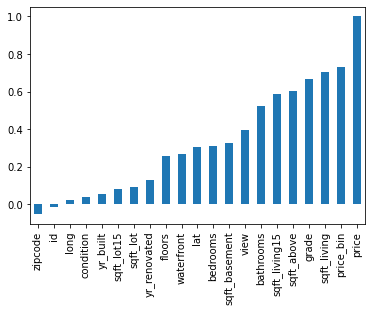

In [16]:
df.corr()['price'].sort_values().plot(kind = 'bar')
# grade, sqft_living mocno koreluja z cena

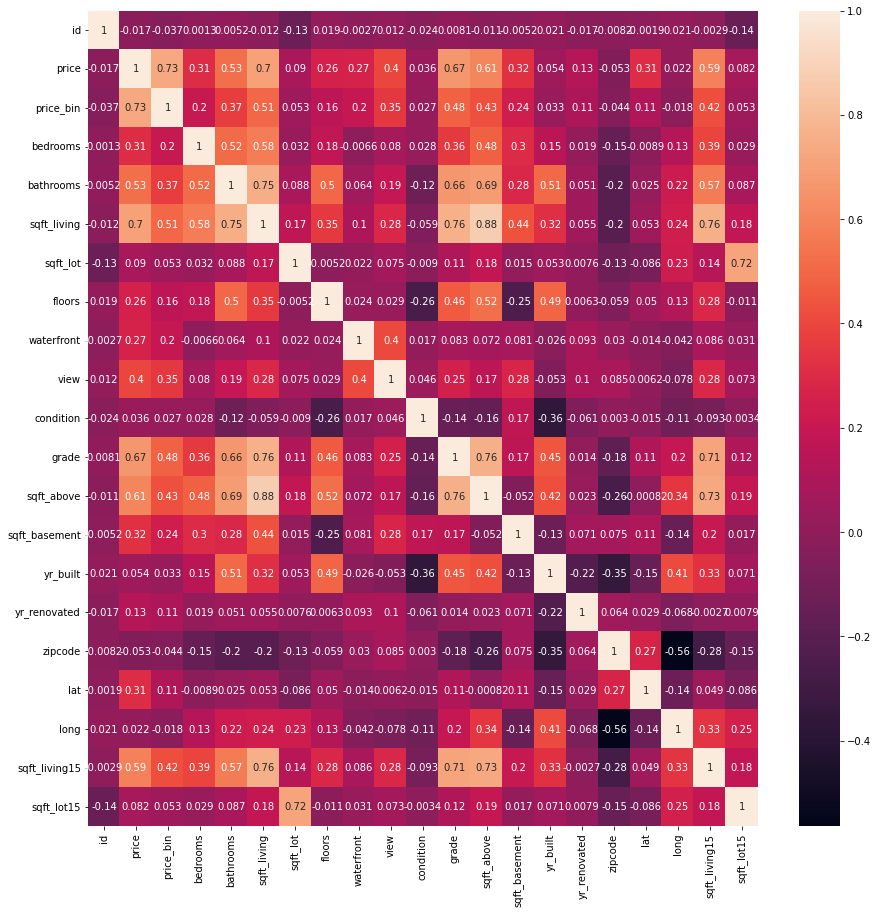

In [17]:
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(),annot = True)

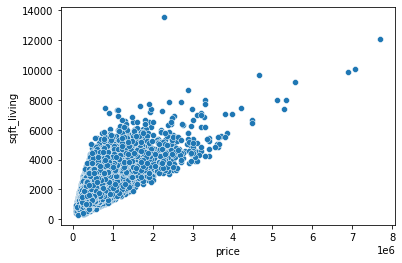

In [18]:
sns.scatterplot(x ='price', y ='sqft_living',data = df)

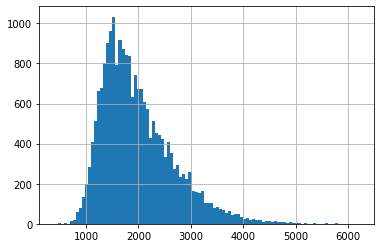

In [19]:
df['sqft_living15'].hist(bins = 100)
# zlogarytmizowac

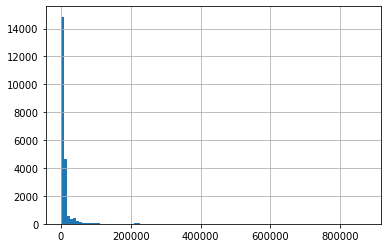

In [20]:
df['sqft_lot15'].hist(bins = 100)
# zlogarytmizowac

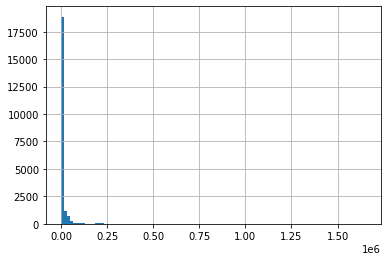

In [21]:
df['sqft_lot'].hist(bins = 100)
# zlogarytmizowac

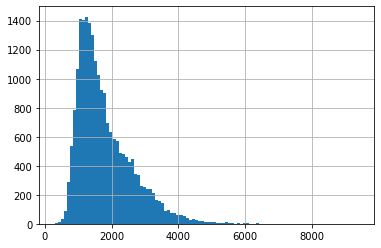

In [22]:
df['sqft_above'].hist(bins = 100)
# Zlogarytmizowac

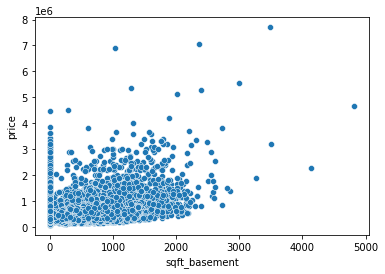

In [23]:
sns.scatterplot(y ='price', x ='sqft_basement',data = df)

In [24]:
df['is_basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)

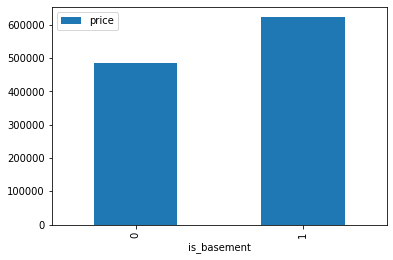

In [25]:
df[['is_basement','price']].groupby(['is_basement']).mean().plot(kind ='bar')

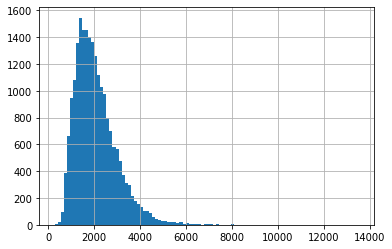

In [26]:
df['sqft_living'].hist(bins = 100)
# zlogarytmizowac

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


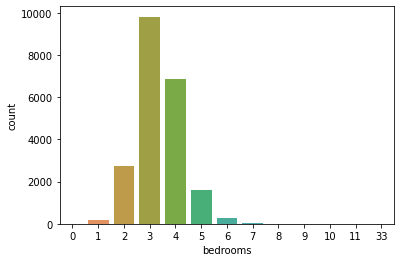

In [27]:
sns.countplot(df['bedrooms'])
# zero pokoi? 33 pokoje? do sprawdzenia

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


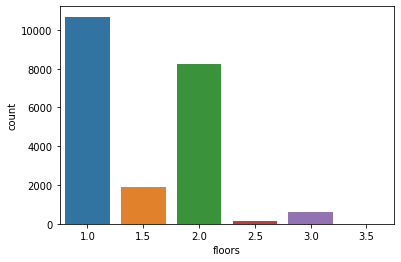

In [28]:
sns.countplot(df['floors'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


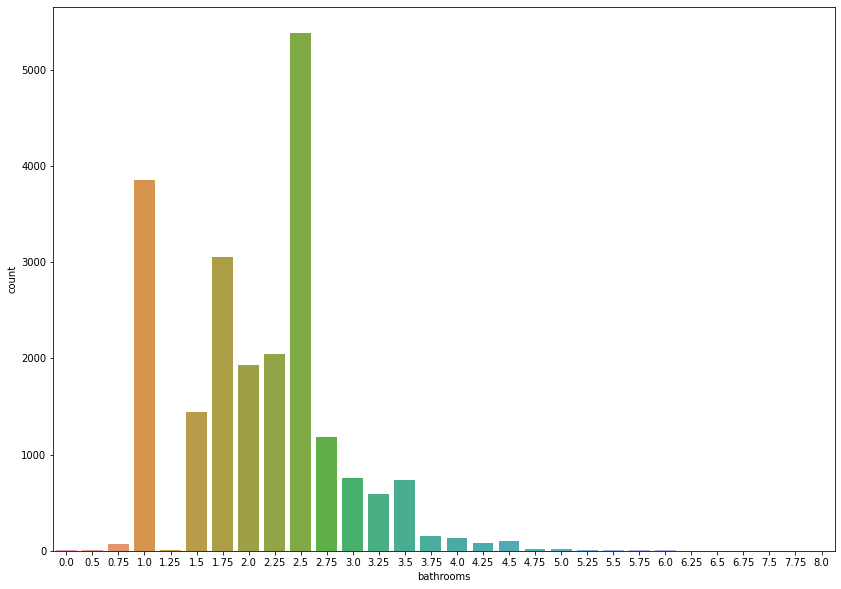

In [29]:
plt.figure(figsize = (14,10))
sns.countplot(df['bathrooms'])
# 2.25 lazienki? Mozna zaokraglic w dol

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


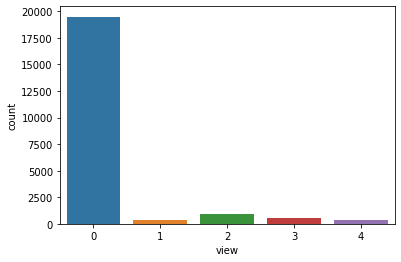

In [30]:
sns.countplot(df['view'])
# kategoryjna zmienna

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


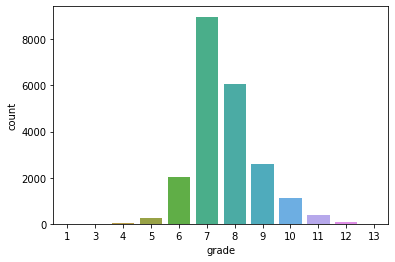

In [31]:
sns.countplot(df['grade'])

In [32]:
df['yr_built'].value_counts()

2014    559
2006    454
2005    450
2004    433
2003    422
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


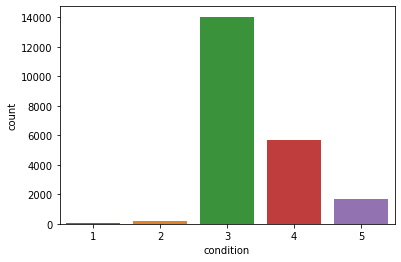

In [33]:
sns.countplot(df['condition'])

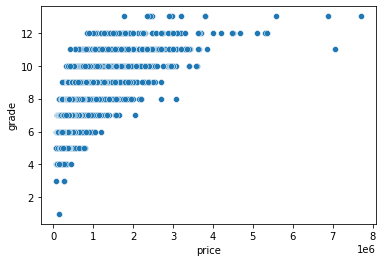

In [34]:
sns.scatterplot(x ='price', y ='grade',data = df)
# kategoryjna zmienna

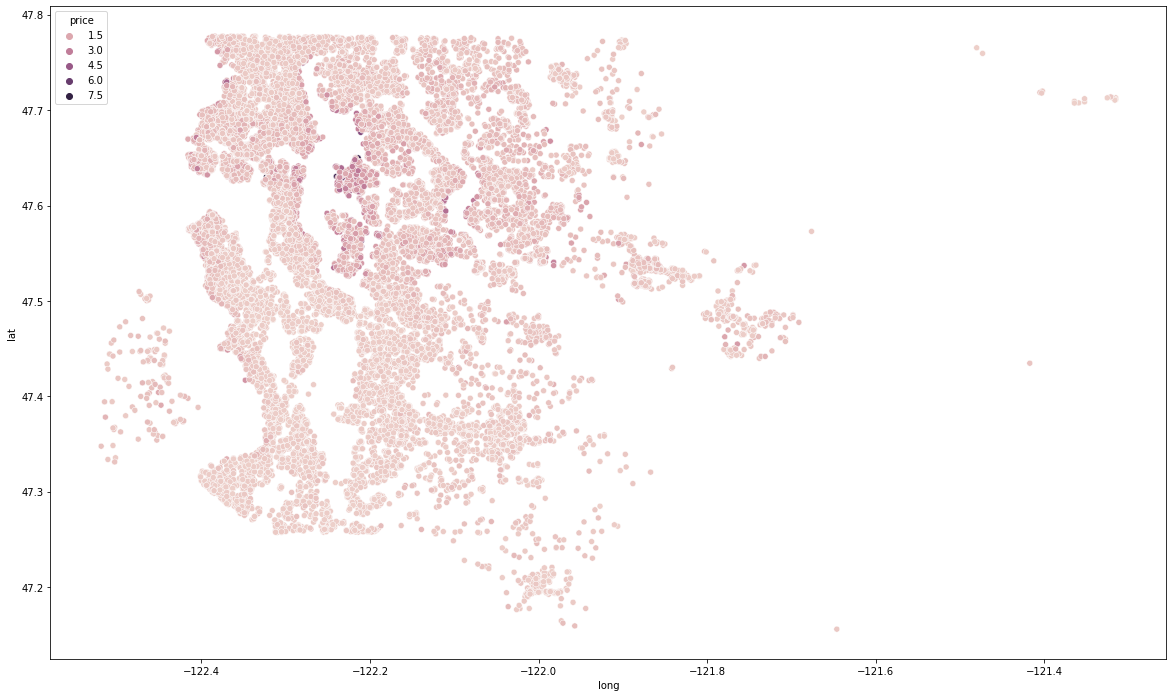

In [35]:
plt.figure(figsize = (20,12))
sns.scatterplot(x = 'long', y = 'lat', data = df,hue='price')
# niektore lokalizacje maja wyzsze ceny (ciemny kolor), np. lat ~ 47.62 i long ~ -122.23

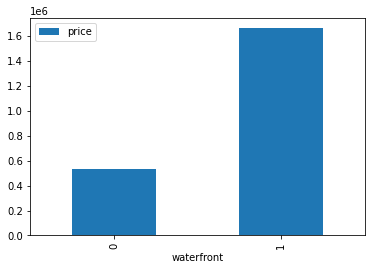

In [36]:
df[['waterfront','price']].groupby(['waterfront']).mean().plot(kind ='bar')
# trzykrotnie wyzsza srednia ceny, gdy mieszkanie jest na nadbrzezu

In [37]:
df['yr_renovated'].value_counts()
# 0 oznacza ze dom nie byl remontowany, zamienie te kolumne mowiaca czy byl remont czy nie

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

# Przygotowanie Danych

In [39]:
# pozbywamy sie 12 outlierow
print(len(df[df['price'] >= 4000000]))
df_without_outliers = df[df['price'] < 4000000]

12


In [40]:
# Wykorzystujemy wiadomosc o dacie
def date_feature_engineering(df):
    df['date'] = pd.to_datetime(df['date'],yearfirst=True)
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["week"] = df["date"].dt.week
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter

    
    return df

In [4]:
df_date_transformed = date_feature_engineering(df_without_outliers)

In [42]:
## sortujemy wedlug daty
df_date_transformed = df_date_transformed.sort_values(by = ['date'],ascending = True)

In [43]:
# Zmiana kolumny na taka ktora mowi czy dom byl remontowany czy nie
df_date_transformed['is_renovated'] = df_date_transformed['yr_renovated'].map(lambda x: 1 if x>0 else 0)
df_date_transformed.drop(['yr_renovated'],axis = 1, inplace = True)

In [44]:
# Logarytmizujemy kolumny
columns_to_log = ['price','sqft_living15','sqft_lot15','sqft_living','sqft_lot','sqft_above']
def logarithm(df,columns_to_log):
  for col in columns_to_log:
    df[col] = np.log(df[col])
  return df


In [45]:
df_logarithmed = logarithm(df_date_transformed,columns_to_log)

In [46]:
# Zamiast pozbywania sie danych gdzie liczba pokoi jest np 33 lub 11 mozna zastapic nowa wartoscia 'Other'
df_logarithmed['bedrooms'].value_counts()

3     9824
4     6880
2     2760
5     1594
6      269
1      199
7       38
8       13
0       13
9        6
10       3
33       1
11       1
Name: bedrooms, dtype: int64

In [47]:
df_without_rare_bedrooms = df_logarithmed[~df_logarithmed['bedrooms'].isin([0,33])]

In [5]:
df_without_rare_bedrooms['bathrooms'] = df_without_rare_bedrooms['bathrooms'].map(lambda x: math.floor(x))

In [49]:
df_without_rare_bedrooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21587 entries, 11577 to 16594
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21587 non-null  int64         
 1   date           21587 non-null  datetime64[ns]
 2   price          21587 non-null  float64       
 3   price_bin      21587 non-null  int64         
 4   bedrooms       21587 non-null  int64         
 5   bathrooms      21587 non-null  int64         
 6   sqft_living    21587 non-null  float64       
 7   sqft_lot       21587 non-null  float64       
 8   floors         21587 non-null  float64       
 9   waterfront     21587 non-null  int64         
 10  view           21587 non-null  int64         
 11  condition      21587 non-null  int64         
 12  grade          21587 non-null  int64         
 13  sqft_above     21587 non-null  float64       
 14  sqft_basement  21587 non-null  int64         
 15  yr_built       

In [50]:
# one hot encoding/ dummy variables
categorical_vars = ['view','dayofweek','week','month','quarter']
enc = OneHotEncoder(sparse = False)

encoder_vars_array = enc.fit_transform(df_without_rare_bedrooms[categorical_vars])

encoder_feature_names = enc.get_feature_names(categorical_vars)

encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)

df_hot_encoded = pd.concat([df_without_rare_bedrooms.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)

df_hot_encoded.drop(categorical_vars, axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Modelowanie

### Regresja --> Przewidywanie ceny

In [52]:
# usuwanie kolumn: id, date, zipcode, price_bin,dayofyear ...
useless_cols = ['id','date','zipcode','price_bin','dayofyear','sqft_basement']
df_dropped_useless_columns = df_hot_encoded.drop(useless_cols, axis = 1)

In [54]:
id = math.ceil(len(df_dropped_useless_columns) * 0.8)
id

17270

In [55]:
# Posortowalem po czasie, zeby np miec dane z lat 2014 - 2016 a przewidywac 2017-2018
# zeby zasymulowac prawdziwy przypadek
df_train = df_dropped_useless_columns[:id]
y_train = df_train['price']
X_train = df_train.drop('price', axis = 1)

df_test = df_dropped_useless_columns[id:]
y_test = df_test['price']
X_test = df_test.drop('price', axis = 1)

#### Automatyzacja podczas trenowania, przy wyborze parametrow uzywajac Hyperopt

In [58]:
def run_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_log_pred = model.predict(X_test)
  
    score = mean_absolute_error(np.exp(y_test),np.exp(y_log_pred))

    return score

In [59]:
def obj_func(params):
    print(params)
    
    mae = run_model(xgb.XGBRegressor(**params),X_train,y_train,X_test,y_test)
    
    return{'loss': np.abs(mae), 'status': STATUS_OK}

xgb_reg_params = {
'learning_rate':     hp.choice('learning_rate',          np.arange(0.05,0.1,0.01)),
'max_depth':         hp.choice("max_depth",              np.arange(20,50,1,dtype = int)),
#'subsample':         hp.quniform('subsample', 0.5, 1, 0.05),
#'colsample_bytree' : hp.quniform('colsample_bytree', 0.5,1,0.05),
'objective' : 'reg:squarederror',
'n_estimators': 300,
'seed': 0
    }
best = fmin(obj_func,xgb_reg_params,algo = tpe.suggest,max_evals = 5)


{'learning_rate': 0.060000000000000005, 'max_depth': 38, 'n_estimators': 300, 'objective': 'reg:squarederror', 'seed': 0}
{'learning_rate': 0.07, 'max_depth': 35, 'n_estimators': 300, 'objective': 'reg:squarederror', 'seed': 0}
{'learning_rate': 0.09000000000000001, 'max_depth': 25, 'n_estimators': 300, 'objective': 'reg:squarederror', 'seed': 0}
{'learning_rate': 0.08000000000000002, 'max_depth': 27, 'n_estimators': 300, 'objective': 'reg:squarederror', 'seed': 0}
{'learning_rate': 0.08000000000000002, 'max_depth': 40, 'n_estimators': 300, 'objective': 'reg:squarederror', 'seed': 0}
100%|██████████| 5/5 [06:27<00:00, 77.51s/it, best loss: 71402.27375600822]


In [60]:
space_eval(xgb_reg_params,best)

{'learning_rate': 0.07,
 'max_depth': 35,
 'n_estimators': 300,
 'objective': 'reg:squarederror',
 'seed': 0}

In [62]:
model_xgb = xgb.XGBRegressor(learning_rate= 0.07, max_depth = 35, n_estimators = 300)
model_xgb.fit(X_train, y_train)

[17:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, max_depth=28, n_estimators=300)

In [63]:
perm = PermutationImportance(model_xgb,random_state= 1).fit(X_train,y_train)

In [64]:
eli5.show_weights(perm,feature_names = list(X_train.columns))

Weight,Feature
0.7115 ± 0.0166,lat
0.1844 ± 0.0016,sqft_living
0.1403 ± 0.0043,grade
0.1197 ± 0.0030,long
0.0610 ± 0.0017,sqft_lot
0.0411 ± 0.0008,yr_built
0.0255 ± 0.0003,sqft_living15
0.0232 ± 0.0011,view_0
0.0192 ± 0.0003,sqft_above
0.0185 ± 0.0002,sqft_lot15


In [65]:
# Uzycie sieci neuronowych

In [66]:
# MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
X_train.shape

(17270, 96)

In [69]:
input_shape = X_train.shape[1]

In [70]:
model = Sequential()

model.add(Dense(input_shape,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(200,activation = 'relu'))
model.add(Dense(200,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'relu'))

model.compile(optimizer = 'adam', loss = 'mae')

In [71]:
model.fit(x = X_train, y = y_train, 
          validation_data=(X_test,y_test),
         batch_size = 32, epochs = 50) #batch = 2^x

Epoch 1/50
540/540 [==============================] - 6s 6ms/step - loss: 1.6669 - val_loss: 0.6479
Epoch 2/50
540/540 [==============================] - 2s 5ms/step - loss: 1.3343 - val_loss: 0.6925
Epoch 3/50
540/540 [==============================] - 2s 4ms/step - loss: 1.2628 - val_loss: 0.5508
Epoch 4/50
540/540 [==============================] - 2s 4ms/step - loss: 1.2575 - val_loss: 0.5900
Epoch 5/50
540/540 [==============================] - 3s 5ms/step - loss: 1.2319 - val_loss: 0.7013
Epoch 6/50
540/540 [==============================] - 2s 4ms/step - loss: 1.1974 - val_loss: 0.6135
Epoch 7/50
540/540 [==============================] - 2s 4ms/step - loss: 1.1761 - val_loss: 0.8710
Epoch 8/50
540/540 [==============================] - 2s 4ms/step - loss: 1.1591 - val_loss: 0.4665
Epoch 9/50
540/540 [==============================] - 2s 5ms/step - loss: 1.1417 - val_loss: 0.3662
Epoch 10/50
540/540 [==============================] - 3s 5ms/step - loss: 1.1039 - val_loss: 0.4116

In [72]:
history = pd.DataFrame(model.history.history)

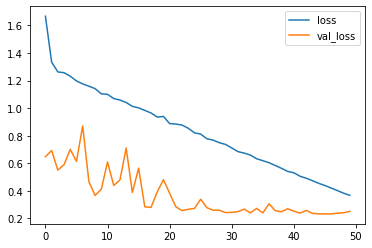

In [73]:
history.plot()

In [74]:
predictions = model.predict(X_test)

In [75]:
mean_absolute_error(np.exp(y_test),np.exp(predictions))

143805.77388811676

### Klasyfikacja Binarna --> Przewidywanie czy wartosc mieszkania powyzej 1mln

In [77]:
# usuwanie kolumn: id, date, zipcode, price_bin,dayofyear ...
useless_cols = ['id','date','zipcode','price','dayofyear','sqft_basement']
df_dropped_useless_columns = df_hot_encoded.drop(useless_cols, axis = 1)

In [79]:
id = math.ceil(len(df_dropped_useless_columns) * 0.8)
id

17270

In [80]:
# Posortowalem po czasie, zeby np miec dane z lat 2014 - 2016 a przewidywac 2017-2018
df_train = df_dropped_useless_columns[:id]
y_train = df_train['price_bin']
X_train = df_train.drop('price_bin', axis = 1)

df_test = df_dropped_useless_columns[id:]
y_test = df_test['price_bin']
X_test = df_test.drop('price_bin', axis = 1)

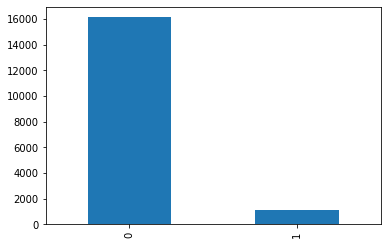

In [81]:
y_train.value_counts().plot(kind ='bar')

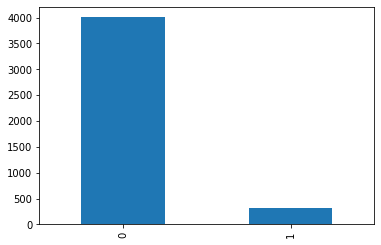

In [82]:
y_test.value_counts().plot(kind ='bar')

#### Automatyzacja podczas trenowania, przy wyborze parametrow uzywajac Hyperopt

In [85]:
def run_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = [round(value) for value in y_pred]
    score = accuracy_score(y_test,y_pred)

    return score

In [86]:
def obj_func(params):
    print(params)
    
    acc = run_model(xgb.XGBClassifier(**params),X_train,y_train,X_test,y_test)
    
    return{'loss': -acc, 'status': STATUS_OK}

xgb_reg_params = {
'learning_rate':     hp.choice('learning_rate',          np.arange(0.05,0.1,0.01)),
'max_depth':         hp.choice("max_depth",              np.arange(20,50,1,dtype = int)),
#'subsample':         hp.quniform('subsample', 0.5, 1, 0.05),
#'colsample_bytree' : hp.quniform('colsample_bytree', 0.5,1,0.05),
'objective' : 'binary:logistic',
'n_estimators': 300,
'seed': 0
    }
best = fmin(obj_func,xgb_reg_params,algo = tpe.suggest,max_evals = 5)


{'learning_rate': 0.09000000000000001, 'max_depth': 38, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 0}
{'learning_rate': 0.05, 'max_depth': 23, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 0}
{'learning_rate': 0.05, 'max_depth': 26, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 0}
{'learning_rate': 0.07, 'max_depth': 49, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 0}
{'learning_rate': 0.07, 'max_depth': 38, 'n_estimators': 300, 'objective': 'binary:logistic', 'seed': 0}
100%|██████████| 5/5 [03:20<00:00, 40.12s/it, best loss: -0.9722029186935371]


In [87]:
space_eval(xgb_reg_params,best)

{'learning_rate': 0.09000000000000001,
 'max_depth': 38,
 'n_estimators': 300,
 'objective': 'binary:logistic',
 'seed': 0}

In [88]:
model_xgb = xgb.XGBClassifier(learning_rate= 0.09, max_depth = 38, n_estimators = 300)
model_xgb.fit(X_train, y_train)

XGBClassifier(learning_rate=0.08, max_depth=35, n_estimators=300)

In [89]:
y_pred_class = model_xgb.predict(X_test)

In [90]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4005
           1       0.89      0.69      0.78       312

    accuracy                           0.97      4317
   macro avg       0.93      0.84      0.88      4317
weighted avg       0.97      0.97      0.97      4317



In [91]:
confusion_matrix(y_test, y_pred_class)

array([[3979,   26],
       [  97,  215]])

In [92]:
perm = PermutationImportance(model_xgb,random_state= 1).fit(X_train,y_train)

In [93]:
eli5.show_weights(perm,feature_names = list(X_train.columns))

Weight,Feature
0.0428 ± 0.0015,lat
0.0369 ± 0.0025,long
0.0237 ± 0.0011,sqft_living
0.0211 ± 0.0008,grade
0.0073 ± 0.0006,sqft_living15
0.0045 ± 0.0004,yr_built
0.0042 ± 0.0005,sqft_above
0.0028 ± 0.0002,view_0
0.0011 ± 0.0003,sqft_lot
0.0009 ± 0.0002,waterfront


# Wnioski wraz z proponowanymi eksperymentami i udoskonaleniami

Do oceny modeli została wykorzystana metryka <b> MAE. </b> W predykcji ceny mieszkania zdecydowanie lepiej poradził sobie algorytm XGBoost, który uzyskał około dwa razy niższy błąd. Wynik uzyskany przy użyciu XGBoost - 71402.27375600822 mówi nam, że średnio nasz model myli się o około 71 tys.  

Proponowane eksperymenty, udoskonalenia:
- bardzo rozsądne wydaje się być stworzenie kolumny średnia_cena_z_okolicy, która zawierala by informacje na temat sredniej ceny w danym obszarze. Można do tego pogrupowac po miesiacu!
- wykorzystanie innych modeli ML tj. Random Forest, SVM czy KNN etc.
- przy automatyzacji parametrow (Hyperopt), mozna wykonac wiecej iteracji i automatyzowac wiecej parametrow
- Można również ograniczyc cechy tylko do tych najistotniejszych wedlug Eli5 
- wykorzystac narzedzie H2O do znalezienia zaleznosci miedzy zmiennymi oraz zbudowaniem roznych modeli predykcyjnych
- automatyzacja modelu sieci przy uzyciu Eli5, dodanie EarlyStoppingu, dodanie liczby epok i wiele innych
- przy problemie klasyfikacji binarnej zbalansowac dane: oversampling lub undersampling
- skorzystanie z informacji na temat położenia geograficznego i zebranie większej ilości danych na przykład na temat temperatury, ceny paliwa, inflacji